In [1]:
import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [10]:
# load the data
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

class_names = metadata.features['label'].names
print('Class names: {}'.format(class_names))

# explore the data
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

# preprocess the data
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of training examples: 60000
Number of test examples:     10000


2022-07-31 06:14:08.137003: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-07-31 06:14:08.137218: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


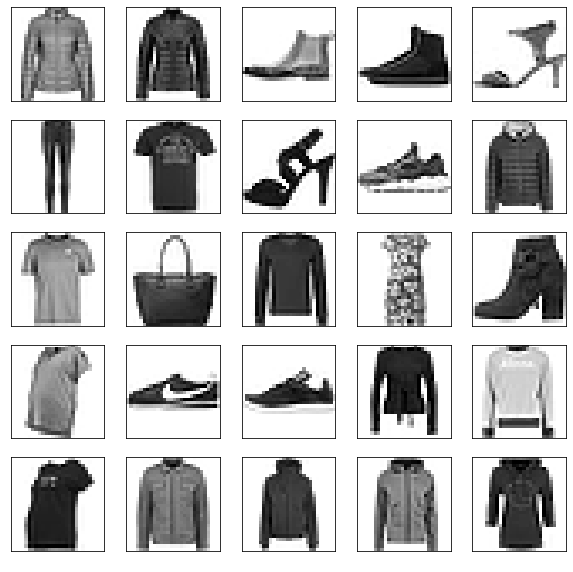

In [4]:
# Plot 25 images
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label], color='white')
    i += 1
plt.show()

In [11]:
BATCH_SIZE = 32
#train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
train_dataset = train_dataset.cache().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

IMG_SIZE = 28

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Build the model
    model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu,
                               input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        #tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])


    #history = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
    history = model.fit(train_dataset, epochs=20)

2022-07-31 06:57:33.192743: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/20
1875/1875 [==============================] - 30s 13ms/step - loss: 0.7622 - accuracy: 0.7229
Epoch 2/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.5516 - accuracy: 0.7984
Epoch 3/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4905 - accuracy: 0.8209
Epoch 4/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4515 - accuracy: 0.8370
Epoch 5/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.4259 - accuracy: 0.8451
Epoch 6/20
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4044 - accuracy: 0.8534
Epoch 7/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3856 - accuracy: 0.8595
Epoch 8/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3713 - accuracy: 0.8657
Epoch 9/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3643 - accuracy: 0.8674
Epoch 10/20
1875/1875 [==============================] - 23s 12m

In [20]:
def plot_learn(history, filename='fine_tune', loc='upper center'):
    
    #plt.style.use('science')
	# plot loss
    fig = plt.figure(facecolor=(1, 1, 1))   
    
    plt.subplot(2,1,1)
    
    plt.title('Cross Entropy Loss - ' + filename)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.yticks(np.arange(0.0, 1.0, 0.1))
    
    plt.legend(loc=loc, prop={'size': 8})
    plt.grid()
    plt.subplots_adjust(hspace=0.5, wspace =0.5)

    # plot accuracy
    plt.subplot(2,1,2)
    plt.title('Classification Accuracy - ' + filename)
    plt.plot(history.history['auc'], color='blue', label='train')
    plt.plot(history.history['val_auc'], color='orange', label='validation')
    plt.yticks(np.arange(0.7, 1.0, 0.1))
    plt.legend(loc='lower right', prop={'size': 8})
    plt.grid()
   

    plt.show()

    # save plot to file

    plt.savefig(filename + '_plot.png')
    plt.close()

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset: ', test_accuracy)

2022-07-31 07:29:28.516773: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


313/313 [==============================] - 4s 6ms/step - loss: 0.4338 - accuracy: 0.8447
Accuracy on test dataset:  0.8446999788284302


Exception ignored in: <function Pool.__del__ at 0x7f6c80e65040>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/multiprocessing/pool.py", line 268, in __del__
    self._change_notifier.put(None)
  File "/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/multiprocessing/queues.py", line 368, in put
    self._writer.send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function Pool.__del__ at 0x7f6c80e65040>
Traceback (most recent ca

In [48]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)
print(predictions.shape)
print(predictions[0], np.argmax(predictions[0]), test_labels[0])

def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label], 
                                         100*np.max(predictions_array), 
                                         class_names[true_label]),
                                         color='white')
    
def plot_value_array(i, predictions_array, true_label):
      predictions_array, true_label = predictions_array[i], true_label[i]
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      thisplot = plt.bar(range(10), predictions_array, color="#777777")
      plt.ylim([0, 1])
      predicted_label = np.argmax(predictions_array)
      thisplot[predicted_label].set_color('red')
      thisplot[true_label].set_color('blue')

2022-07-30 21:28:54.708291: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1642861"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:573"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

1/1 [==============================] - 1s 1s/step
(32, 10)
[2.9683681e-10 1.0697219e-08 2.3349818e-04 3.5088912e-10 9.9810290e-01
 8.5089985e-10 1.6635183e-03 2.9825691e-09 2.9349551e-10 4.7306062e-11] 4 4


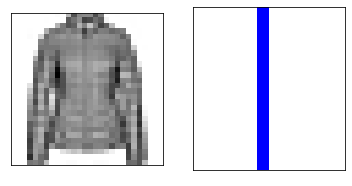

In [49]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

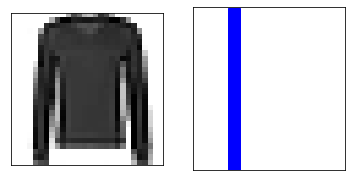

In [50]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

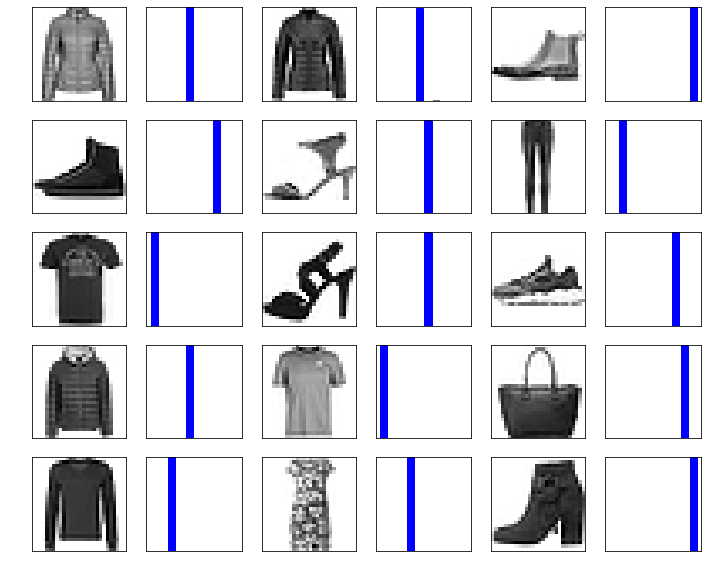

In [51]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

(28, 28, 1)
(1, 28, 28, 1)


2022-07-30 20:08:39.671996: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1244763"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:342"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

1/1 [==============================] - 2s 2s/step
[[1.2218100e-08 5.4711351e-09 1.1737782e-04 2.1794064e-10 9.7951150e-01
  2.0423500e-11 2.0370897e-02 2.0726426e-10 1.3731522e-08 2.0164821e-07]]


4

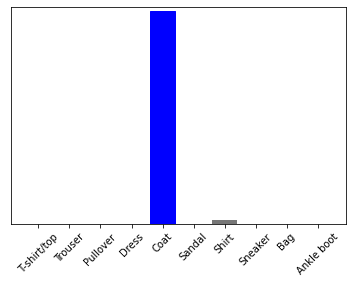

In [36]:
img = test_images[0]
print(img.shape)
img = np.array([img])
print(img.shape)
predictions_single= model.predict(img)
print(predictions_single)
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
np.argmax(predictions_single[0])